In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

In [6]:
result_file =  "/Users/richardbieringa/Projects/mesh-bench/results/micro-bench/01_workload/2-nodes.json"

with open(result_file) as f:
    data  = json.load(f)

data

{'RunType': 'HTTP',
 'Labels': '',
 'StartTime': '2022-07-01T13:25:57.49826142Z',
 'RequestedQPS': 'max',
 'RequestedDuration': '15m0s',
 'ActualQPS': 25169.62259517342,
 'ActualDuration': 900000423699,
 'NumThreads': 4,
 'Version': '1.28.0',
 'DurationHistogram': {'Count': 22652671,
  'Min': 5.9961e-05,
  'Max': 0.140659423,
  'Sum': 3594.730939191965,
  'Avg': 0.0001586890543367696,
  'StdDev': 0.0002302022212411988,
  'Data': [{'Start': 5.9961e-05,
    'End': 0.001,
    'Percent': 99.74081643617214,
    'Count': 22593959},
   {'Start': 0.001,
    'End': 0.002,
    'Percent': 99.89589307150578,
    'Count': 35129},
   {'Start': 0.002, 'End': 0.003, 'Percent': 99.93818830459331, 'Count': 9581},
   {'Start': 0.003, 'End': 0.004, 'Percent': 99.95708673824822, 'Count': 4281},
   {'Start': 0.004, 'End': 0.005, 'Percent': 99.96927956089593, 'Count': 2762},
   {'Start': 0.005, 'End': 0.006, 'Percent': 99.97900909786753, 'Count': 2204},
   {'Start': 0.006, 'End': 0.007, 'Percent': 99.9867521

In [8]:
binned_data = data["DurationHistogram"]["Data"]

[{'Start': 5.9961e-05,
  'End': 0.001,
  'Percent': 99.74081643617214,
  'Count': 22593959},
 {'Start': 0.001, 'End': 0.002, 'Percent': 99.89589307150578, 'Count': 35129},
 {'Start': 0.002, 'End': 0.003, 'Percent': 99.93818830459331, 'Count': 9581},
 {'Start': 0.003, 'End': 0.004, 'Percent': 99.95708673824822, 'Count': 4281},
 {'Start': 0.004, 'End': 0.005, 'Percent': 99.96927956089593, 'Count': 2762},
 {'Start': 0.005, 'End': 0.006, 'Percent': 99.97900909786753, 'Count': 2204},
 {'Start': 0.006, 'End': 0.007, 'Percent': 99.98675211413259, 'Count': 1754},
 {'Start': 0.007, 'End': 0.008, 'Percent': 99.99078254392164, 'Count': 913},
 {'Start': 0.008,
  'End': 0.009000000000000001,
  'Percent': 99.99274257768543,
  'Count': 444},
 {'Start': 0.009000000000000001,
  'End': 0.01,
  'Percent': 99.99453927530223,
  'Count': 407},
 {'Start': 0.01, 'End': 0.011, 'Percent': 99.99659642785612, 'Count': 466},
 {'Start': 0.011, 'End': 0.012, 'Percent': 99.9973204042914, 'Count': 164},
 {'Start': 0.0

In [15]:
samples  = []
for bin in binned_data:
    # Samples are uniformly distributed over the half-open interval [low, high)
    # (includes low, but excludes high).
    low = bin["Start"]
    high = bin["End"]
    size = bin["Count"]
    samples.append(np.random.uniform(low=low, high=high, size=size))

In [23]:
sampled_data = np.concatenate(samples)
sampled_data = sampled_data * 1000

In [27]:
s = pd.Series(sampled_data, "latency")
s

0             0.823876
1             0.844635
2             0.889253
3             0.535233
4             0.343590
               ...    
22652666     87.771310
22652667     80.975206
22652668     92.654483
22652669    116.912051
22652670    140.053909
Length: 22652671, dtype: float64

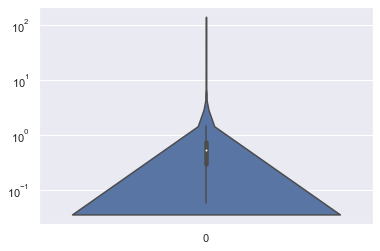

In [32]:
ax = sns.violinplot(data=s, x="latency")
ax.set_yscale("log")

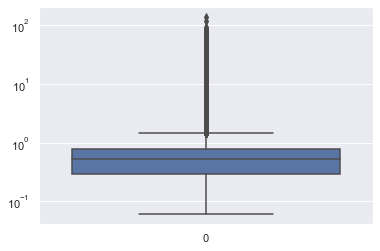

In [31]:
ax = sns.boxplot(data=s)
ax.set_yscale("log")